Training from several snapshots of data

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def in_out(auxhist, wrfout): #outputs the required input and output data from the auxhist and wrfout files
    DS_a = xr.open_dataset(auxhist) #dataset of auxhist
    DS_w = xr.open_dataset(wrfout) #dataset of wrfout
    
    T = (DS_w.T.values + DS_w.T0) * ((DS_w.P.values + DS_w.PB.values)/DS_w.P0)**(DS_w.R_D/DS_w.CP)
    st = DS_w.TSK.values #surface temp
    d_c = DS_w.TAU_OD.values #dust optical depth
    em = DS_w.EMISS.values #emissivity
    p = DS_w.P.values + DS_w.PB.values #pressure
    uif = DS_a.UPIRFLUX.values[1:,:,:,:] 

    temp_uif = []
    for i in range(52):
        temp_uif.append(uif[:,i,:,:].reshape(-1))
    uif = np.array(temp_uif).T
    uif.shape


    sla = [] #special layer arrays that are the feature vectors in the linear regression model
    sla.append((em*st**4).reshape(-1)) #don't have overall opacity, will deal with this issue later
    for i in range(52): #using all the layers now
        sla.append((np.exp(-d_c[:,i,:,:])*T[:,i,:,:]**4).reshape(-1))
    for i in range(52): #using all the layers now
        sla.append((np.exp(-p[:,i,:,:])*T[:,i,:,:]**4).reshape(-1))
    sla = np.array(sla)
    sla = sla.T[2592:,:] #take transpose, remove first day of data (all lwr are 0 there)
    
    return sla, uif

In [3]:
sla1, uif1 = in_out('af', 'wf') #first snapshot of data

In [4]:
sla2, uif2 = in_out('af2', 'wf2') #some snapshot of data about half a martian year later

In [5]:
sla3, uif3 = in_out('af3', 'wf3') #this will be the test set

In [6]:
uif_train = np.concatenate((uif1, uif2), axis=0) #total uif for training

In [7]:
sla_train = np.concatenate((sla1, sla2), axis=0) #total sla for training

In [13]:
uif3.shape

(619488, 52)

# Linear regression

In [14]:
from sklearn.linear_model import LinearRegression
lr1 = LinearRegression()
lr1.fit(sla_train,uif_train)
uif_lin = lr1.predict(sla3) 

In [17]:
lr1.coef_

array([[ 3.2148638e-08,  3.9497991e-08, -2.0523832e-08, ...,
         3.7319933e-07, -5.8752426e-07,  6.7441702e-06],
       [ 3.2148645e-08,  3.9497774e-08, -2.0523826e-08, ...,
         3.7319566e-07, -5.8753790e-07,  6.7441219e-06],
       [ 3.2148670e-08,  3.9497770e-08, -2.0523625e-08, ...,
         3.7319384e-07, -5.8754722e-07,  6.7440856e-06],
       ...,
       [ 3.7258136e-08,  3.8624684e-08, -1.8065194e-08, ...,
        -5.4276306e-08,  3.2995453e-07,  2.2878282e-06],
       [ 3.7522060e-08,  3.9159289e-08, -1.8172312e-08, ...,
        -5.2143626e-08,  3.3549998e-07,  2.2066292e-06],
       [ 3.7887322e-08,  4.0012594e-08, -1.7974017e-08, ...,
        -4.5763141e-08,  3.4075762e-07,  2.1002625e-06]], dtype=float32)

In [18]:
from sklearn.metrics import mean_squared_error
uif_out = uif3
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

11.788815

In [19]:
np.min(uif_out)

16.084946

In [20]:
np.max(uif_out)

489.8716

In [21]:
uif_diff = uif_out - uif_lin

In [25]:
np.where(uif_diff > 50)

(array([   694,    694,    694, ..., 519240, 519240, 529608], dtype=int64),
 array([46, 47, 48, ..., 50, 51, 51], dtype=int64))

<function matplotlib.pyplot.show(*args, **kw)>

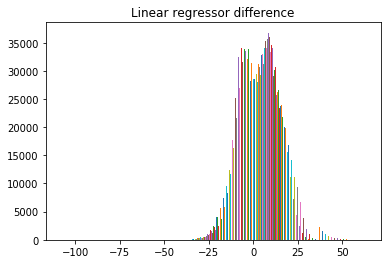

In [26]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [27]:
uif_out.reshape(-1,1).shape

(32213376, 1)

In [29]:
real_out = uif_out[10*36*72:11*36*72,10].reshape(36,72)
pred_out = uif_lin[10*36*72:11*36*72,10].reshape(36,72)

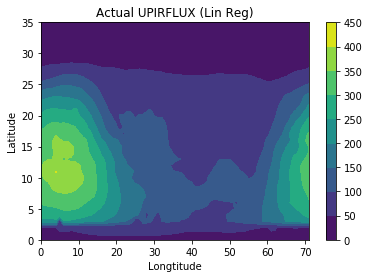

In [30]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

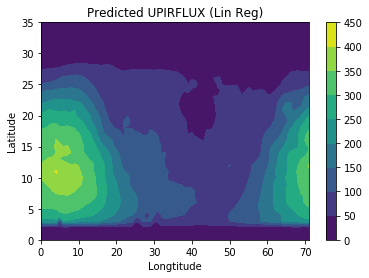

In [31]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

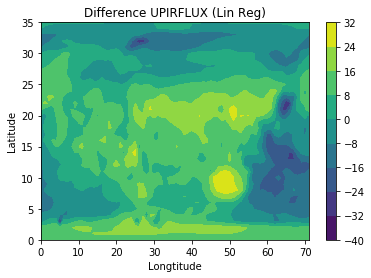

In [32]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

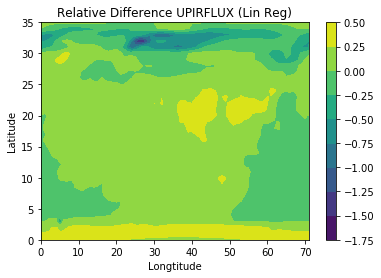

In [33]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [34]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [35]:
real_out.shape

(36, 72)

In [36]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [37]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[4.56158091, 4.21606487, 4.70472137, ..., 5.59596718, 6.01581654,
        5.91191473],
       [4.56163609, 4.21612249, 4.7047886 , ..., 5.59600399, 6.01584316,
        5.91194801],
       [4.56163873, 4.21605514, 4.70478672, ..., 5.59607184, 6.01588212,
        5.91197837],
       ...,
       [7.16388534, 6.23432768, 7.35092437, ..., 8.31830521, 9.52345155,
        8.64237785],
       [7.09541326, 6.1456247 , 7.27656483, ..., 8.28797949, 9.51672706,
        8.60596946],
       [7.00077048, 6.01315077, 7.17951863, ..., 8.2388664 , 9.49169057,
        8.53461934]])

In [38]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([6.39347973, 6.39349978, 6.39352043, 6.39299838, 6.39316256,
       6.3929721 , 6.39299781, 6.39286485, 6.39286201, 6.39286254,
       6.39379544, 6.3948388 , 6.39643204, 6.39924155, 6.4032312 ,
       6.41057726, 6.42174004, 6.43368101, 6.44396566, 6.45636626,
       6.47325919, 6.49699282, 6.53102586, 6.58160114, 6.64734138,
       6.73187422, 6.8363285 , 6.96499207, 7.11931239, 7.29725151,
       7.50263982, 7.73161653, 7.9773416 , 8.2356961 , 8.49398979,
       8.75419561, 8.99920934, 9.2107245 , 9.43564445, 9.51173613,
       9.5804716 , 9.61844257, 9.65608417, 9.68951739, 9.718213  ,
       9.73410318, 9.74644371, 9.75418229, 9.75707331, 9.75557424,
       9.74566178, 9.71847214])

In [39]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([4.21606487, 4.21612249, 4.21605514, 4.21540973, 4.21534109,
       4.21509496, 4.21548052, 4.21553518, 4.21544373, 4.21548541,
       4.21625962, 4.21654544, 4.21715445, 4.21899576, 4.22208446,
       4.22749039, 4.23534026, 4.24489836, 4.25913707, 4.27837163,
       4.29907193, 4.3235042 , 4.35518916, 4.399476  , 4.45631672,
       4.53043796, 4.62515516, 4.73981568, 4.87204149, 5.02106336,
       5.1946339 , 5.38838158, 5.5951999 , 5.80709547, 6.01341548,
       6.20944533, 6.38027945, 6.50542073, 6.55672592, 6.55558151,
       6.53801542, 6.51885018, 6.49388714, 6.45878116, 6.41331668,
       6.37702197, 6.33573218, 6.28753055, 6.22209068, 6.13850712,
       6.03784968, 5.90978421])

In [40]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.48828672, 0.48827156, 0.48828642, 0.48830508, 0.48829498,
       0.48828946, 0.4881839 , 0.48813273, 0.48815597, 0.48814339,
       0.48817482, 0.48830289, 0.48853604, 0.48887549, 0.48926115,
       0.48987215, 0.49072576, 0.49117269, 0.49022909, 0.48880569,
       0.48835528, 0.48920792, 0.49093761, 0.49321919, 0.49594555,
       0.49960728, 0.50387779, 0.50910015, 0.51611938, 0.52525183,
       0.53624411, 0.54917851, 0.56427104, 0.5824914 , 0.60220019,
       0.62259837, 0.64709042, 0.68112051, 0.7174205 , 0.73398107,
       0.75282553, 0.76542261, 0.7792171 , 0.7940091 , 0.80950272,
       0.82033228, 0.83176577, 0.84402221, 0.85782173, 0.87380948,
       0.89261332, 0.91621518])

In [41]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([5.36170813, 5.36173393, 5.36175241, 5.36117642, 5.36124808,
       5.36092498, 5.3609799 , 5.36092291, 5.36096866, 5.3609636 ,
       5.36142828, 5.36155118, 5.36258271, 5.36554211, 5.36993268,
       5.3767473 , 5.38596972, 5.39619946, 5.40827431, 5.42365844,
       5.44226125, 5.46709677, 5.50145939, 5.55075123, 5.61410177,
       5.69541026, 5.79664438, 5.92080855, 6.06779046, 6.23548317,
       6.42946415, 6.64701091, 6.88046964, 7.12354903, 7.36495879,
       7.6117753 , 7.84478239, 8.04483377, 8.17072326, 8.20342258,
       8.22503105, 8.23207767, 8.2359483 , 8.23302259, 8.22338088,
       8.21249793, 8.19748566, 8.17737637, 8.14996111, 8.11271976,
       8.06052849, 7.98091076])

In [42]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
6.482269285264112


These are much higher values than in ML3.3.3.